# Задание 02

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kimaril/networksch/master)

[<img src=https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png width="100">](https://github.com/kimaril/networksch)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
from math import ceil
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from ipywidgets import interact
%matplotlib inline

In [2]:
def eigenvector_centrality(G):
    return nx.eigenvector_centrality(G, max_iter=500)

Будем изучать важность персонажей в книгах "A Song of Ice and Fire" (G.R.R. Martin). Два героя связаны ребром, если их имена появляются в тексте на расстоянии не более 15 слов в соответствующей книге. [Данные](https://github.com/mathbeveridge/asoiaf) находятся в открытом доступе для 5 книг.
Сеть $-$ взвешенная, вес ребра определяется числом взаимодействий (упоминаний в тексте).

In [3]:
book1 = pd.read_csv('../data/got/asoiaf-book1-edges.csv')
book2 = pd.read_csv('../data/got/asoiaf-book2-edges.csv')
book3 = pd.read_csv('../data/got/asoiaf-book3-edges.csv')
book4 = pd.read_csv('../data/got/asoiaf-book4-edges.csv')
book5 = pd.read_csv('../data/got/asoiaf-book5-edges.csv')

In [4]:
book5.head()

,Source,Target,Type,weight,book
0,Aegon-I-Targaryen,Daenerys-Targaryen,undirected,4,5
1,Aegon-Targaryen-(son-of-Rhaegar),Daenerys-Targaryen,undirected,11,5
2,Aegon-Targaryen-(son-of-Rhaegar),Elia-Martell,undirected,4,5
3,Aegon-Targaryen-(son-of-Rhaegar),Franklyn-Flowers,undirected,3,5
4,Aegon-Targaryen-(son-of-Rhaegar),Haldon,undirected,14,5


In [5]:
G1 = nx.from_pandas_edgelist(book1,'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [6]:
G2 = nx.from_pandas_edgelist(book2,'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [7]:
G3 = nx.from_pandas_edgelist(book3,'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [8]:
G4 = nx.from_pandas_edgelist(book4,'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [9]:
G5 = nx.from_pandas_edgelist(book5,'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [10]:
graphs = [G1, G2, G3, G4, G5]

#### Постройте сеть персонажей по первой книге. 

In [11]:
print(list(G1.edges(data=True))[16]) # ребро в сети

('Jaime-Lannister', 'Loras-Tyrell', {'Source': 'Jaime-Lannister', 'Target': 'Loras-Tyrell', 'Type': 'Undirected', 'weight': 3, 'book': 1})


In [12]:
def getTop(G, centrality, n=10):
    return {k:v for k, v in sorted(centrality(G).items(), key=lambda x:x[-1], reverse=True)[:n]}

#### 1.  Определите топ-10 персонажей по значению центральности по степени. Сколько среди них Старков? 

In [13]:
top10_degree_centrality = getTop(G1, nx.degree_centrality)

In [14]:
print('Num. of Starks in top-10: {}'.format(sum(['stark' in n.lower() for n,c 
                                                 in top10_degree_centrality.items()])))

Num. of Starks in top-10: 5


#### 2. Постройте функцию weighted_degree, учитывающую вес ребер: 

$$d_{w}^{i}=\sum_{j} w_{i,j},$$ где $w_{i,j}$ -- вес ребра $(i,j)$ ($w_{i,j}=0$, если нет ребра между вершинами $i$ и $j$).

#### Какое значение взвешенной степени у Eddard-Stark в сети?

In [15]:
def weighted_degree(G, node=None):
    if node:
        edges = G.edges(node)
        wd = sum(G.get_edge_data(u, v)['weight'] for u, v in edges)
        return wd
    else:
        return {n:weighted_degree(G, n) for n in G.nodes()}

In [16]:
print('Eddard Stark weighted degree: {}'.format(weighted_degree(G1, 'Eddard-Stark')))

Eddard Stark weighted degree: 1284


#### 3. Сколько персонажей из топ-10, определенным по центральности по степени (из вопроса 1) осталось в топ-10 по взвешенной степени ? 

In [17]:
top10_weighted_degree = getTop(G1, weighted_degree)

In [18]:
print('Answer: {}'.format(len(set(top10_weighted_degree.keys()).intersection(top10_degree_centrality.keys()))))

Answer: 8


#### 4.  Постройте топ-10 персонажей  по значению центральности по посредничеству. 
Сравните с топ-10 по степени и по взвешенной степени. 

In [19]:
top10_betweenness = getTop(G1, nx.betweenness_centrality)

In [20]:
top10_betweenness

{'Eddard-Stark': 0.2696038913836117,
 'Robert-Baratheon': 0.21403028397371796,
 'Tyrion-Lannister': 0.1902124972697492,
 'Jon-Snow': 0.17158135899829566,
 'Catelyn-Stark': 0.1513952715347627,
 'Daenerys-Targaryen': 0.08627015537511595,
 'Robb-Stark': 0.07298399629664767,
 'Drogo': 0.06481224290874964,
 'Bran-Stark': 0.05579958811784442,
 'Sansa-Stark': 0.03714483664326785}

#### Какой новый персонаж появился в рейтинге?

In [21]:
new_character = set(top10_betweenness.keys()).difference(top10_degree_centrality.keys()).\
                difference(top10_weighted_degree)
print('Answer: {}'.format(new_character.pop()))

Answer: Drogo


#### 5. Постройте топ-10 персонажей по значению центральности по посредничеству с учетом веса ребер. Кто теперь возглавляет список? 

In [22]:
weighted_betweenness_centrality = lambda G : nx.betweenness_centrality(G, weight='weight')

In [23]:
getTop(G1, weighted_betweenness_centrality)

{'Robert-Baratheon': 0.23341885664466297,
 'Eddard-Stark': 0.18703429235687297,
 'Tyrion-Lannister': 0.15311225972516293,
 'Robb-Stark': 0.1024018949825402,
 'Catelyn-Stark': 0.10169012330302643,
 'Jon-Snow': 0.09027684366394043,
 'Jaime-Lannister': 0.07745109164464009,
 'Rodrik-Cassel': 0.07667992877670296,
 'Drogo': 0.06894355184677767,
 'Jorah-Mormont': 0.0627085149665795}

In [24]:
print(getTop(G1, weighted_betweenness_centrality, 1))

{'Robert-Baratheon': 0.23341885664466297}


####  6. Постройте топ-10 по значению PageRank (по умолчанию учитываются веса ребер). Какое место в топе  занимает Daenerys-Targaryen?

In [25]:
top10_pagerank = getTop(G1, nx.pagerank)

In [26]:
for e, n in enumerate(top10_pagerank, 1):
    if n=='Daenerys-Targaryen':
        print('Answer: {}'.format(e))

Answer: 8


#### 7. Постройте рейтинг по значению центральности по степени для персонажей 5-ой книги. Какую теперь наивысшую строчку рейтинга занимает персонаж из Дома Старков?  

In [27]:
stark5 = list(filter(lambda x : 'stark' in x[-1].lower(), 
                     enumerate(getTop(G5, nx.degree_centrality, n=None), 1)))

In [28]:
print('Answer: {} place, {}'.format(*stark5[0]))

Answer: 21 place, Eddard-Stark


#### 8.  Выберите персонажа и постройте график, показывающий как менялась его влиятельность от номера книги. 

In [29]:
def getRank(G, centrality, character=None):
    if character:
        return list(filter(lambda x : x[-1]==character, enumerate(getTop(G, centrality, n=None), 1)))[0][0]
    else:
        return {k:i for i, (k, v) in enumerate(getTop(G, centrality, n=None).items(), 1)}

def getCharacterCentralities(G, character=None):
    if character:
        return {'degree' : getRank(G, nx.degree_centrality, character), 
                'weighted_degree' : getRank(G, weighted_degree, character), 
                'eigenvector' : getRank(G, eigenvector_centrality, character),
                'closeness' : getRank(G, nx.closeness_centrality, character),
                'betweenness' : getRank(G, nx.betweenness_centrality, character),
                'weighted_betweenness' : getRank(G, nx.betweenness_centrality, character),
                'pagerank' : getRank(G, nx.pagerank, character)}
    else:
        return {'degree' : getRank(G, nx.degree_centrality), 
                'weighted_degree' : getRank(G, weighted_degree), 
                'eigenvector' : getRank(G, eigenvector_centrality),
                'closeness' : getRank(G, nx.closeness_centrality),
                'betweenness' : getRank(G, nx.betweenness_centrality),
                'weighted_betweenness' : getRank(G, nx.betweenness_centrality),
                'pagerank' : getRank(G, nx.pagerank)}
def evolve(character, graphs, verbose=False):
    evolution = []
    if verbose:
        itGraphs = tqdm(graphs)
    else:
        itGraphs = graphs
    for G in itGraphs:
        evolution.append(getCharacterCentralities(G, character))
    return pd.DataFrame(evolution, index=[1, 2, 3, 4, 5])

def plotSignificance(character, graphs, verbose=False):
    df = evolve(character, graphs, verbose=verbose)*-1
    # specify seaborn palette for plot
    pal = sns.cubehelix_palette(start=2.8, rot=.1, n_colors=df.shape[-1], reverse=False)
    # plot
    plot = sns.lineplot(data=df, markers=True, dashes=False, palette=pal)
    name = " ".join(character.split('-'))
    title = 'Significance of {} through 5 books'.format(name)
    yticks = plt.yticks()[0]
    yticks = np.insert(arr=yticks[yticks < 0].astype(int), obj=0, values=[-1])
    plt.yticks(ticks=yticks, labels=yticks*-1)
    plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel('Books')
    plt.ylabel('Centrality Rank')
    plot.set_title(title)
    return plot

def plotCharactersEvolution(characters : list, verbose=False):
    nrows = ceil(len(characters)/2)
    ncols = len(characters)%2+2
    fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6))

    for ax, character in zip(axis, characters):
        fig.add_subplot(ax, plotSignificance(character, graphs, verbose=verbose))

    plt.show()

<center>State-of-the-art fanfiction analytics presents</center>
<img src=https://vignette.wikia.nocookie.net/gameofthrones/images/4/4b/Littlefinger-sansa_kiss.png/revision/latest?cb=20160826000012 width="400">

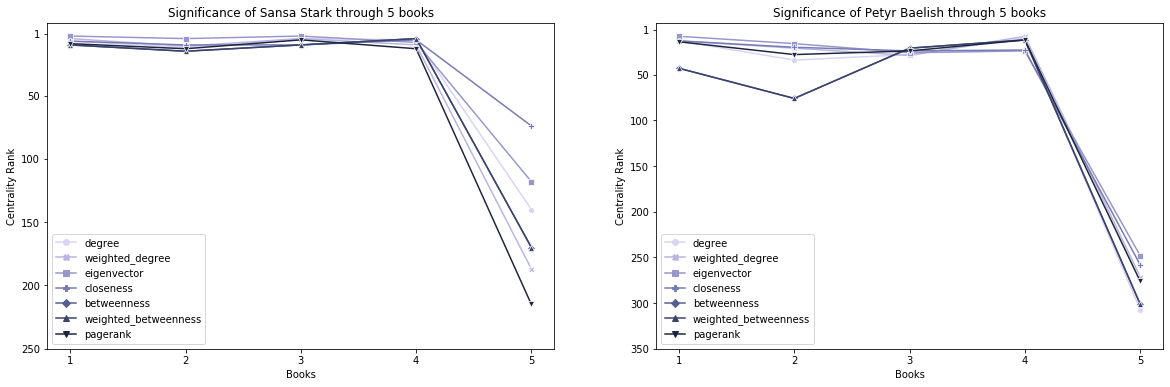

In [30]:
plotCharactersEvolution(characters=['Petyr-Baelish', 'Sansa-Stark'], verbose=False)

#### 9. Кто из персонажей самый влиятельный? 
Постройте сеть, объединяющую сети по всем книгам. Постройте таблицу наиболее влиятельных персонажей в зависимости от выбранной метрики.

In [32]:
grouped = pd.concat([book1, book2, book3, book4, book5], axis=0).groupby(['Source', 'Target'])['weight'].sum()
edges = np.array([np.array(pair) for pair in grouped.index.to_numpy()])
books = pd.DataFrame(data={'Source' : edges[:,0], 'Target' : edges[:, 1], 
                          'weight' : grouped.values, 'type' : ['Undirected']*grouped.shape[0]})

In [33]:
G = nx.from_pandas_edgelist(books, 'Source', 'Target', edge_attr=True, create_using=nx.Graph())

In [34]:
totalCentralities = getCharacterCentralities(G)
df = pd.DataFrame(totalCentralities)

In [35]:
df.index = df.index.map(lambda x : ' '.join(x.split('-')))

In [36]:
@interact
def showTop10(col=df.columns, topn=(1, 30)):
    def highlight_cols(s):
        color = sns.cubehelix_palette(start=2.8, rot=.1, n_colors=20).as_hex()[df.columns.get_loc(col)]
        return 'background-color: %s' % color
    return df.sort_values(by=col, ascending=True).head(topn).style.\
           applymap(highlight_cols, subset=pd.IndexSlice[:, [col]])

interactive(children=(Dropdown(description='col', options=('degree', 'weighted_degree', 'eigenvector', 'closen…